In [4]:
import numpy as np
import sympy as sp

sp.init_printing()

x = np.array([1,0,0,0,0,0,0,0])


In [ ]:

sp.init_printing()
t1, t2 = sp.symbols('t1 t2')
def RX(params):
  params =sp.symbols(params,real=True,)
  _RX = np.array([[sp.cos(params/2),-sp.I*sp.sin(params/2)],[-sp.I*sp.sin(params/2),sp.cos(params/2)]])
  return _RX

def RY(params):
  params =sp.symbols(params ,real=True,)
  _RY = np.array([[sp.cos(params/2),-1*sp.sin(params/2)],[sp.sin(params/2),sp.cos(params/2)]])
  return _RY


def Z_3(s='IZI'):
  m_dict = {
    'Z' : np.array([[1,0],[0,-1]]),
    'I' : np.eye(2)
  }
  result = np.kron(np.kron(m_dict[s[0]], m_dict[s[1]]), m_dict[s[2]])
  return result

def pqc(layer):
  C_NOT =np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

  I_CNOT= np.kron(np.eye(2),C_NOT)
  CNOT_I= np.kron(C_NOT,np.eye(2))
  angle_embeding = np.kron(np.kron(RX('x1'),RX('x2')),np.eye(2))
  cnot_layer = I_CNOT @CNOT_I
  for i in range(layer):
    tmp=np.eye(8)
    pqc_layer =np.kron(np.kron(RY(f't{i+1}'),RY(f't{i+2}')),RY(f't{i+3}'))
    tmp = tmp@pqc_layer@cnot_layer
  tmp =tmp@cnot_layer@angle_embeding
  return tmp

In [ ]:
ans =sp.trigsimp(pqc(3))
x = np.array([1,0,0,0,0,0,0,0])
x= x.reshape(8,1)
res= ans@x

In [ ]:
res

array([[1.0*(sin(t3/2)*sin(t4/2)*sin(t5/2)*sin(x1/2)*sin(x2/2) - I*sin(t3/2)*sin(t5/2)*sin(x1/2)*cos(t4/2)*cos(x2/2) + I*sin(t4/2)*sin(x2/2)*cos(t3/2)*cos(t5/2)*cos(x1/2) + cos(t3/2)*cos(t4/2)*cos(t5/2)*cos(x1/2)*cos(x2/2))],
       [1.0*(-sin(t3/2)*sin(t4/2)*sin(x1/2)*sin(x2/2)*cos(t5/2) + I*sin(t3/2)*sin(x1/2)*cos(t4/2)*cos(t5/2)*cos(x2/2) + I*sin(t4/2)*sin(t5/2)*sin(x2/2)*cos(t3/2)*cos(x1/2) + sin(t5/2)*cos(t3/2)*cos(t4/2)*cos(x1/2)*cos(x2/2))],
       [1.0*(-I*sin(t3/2)*sin(t4/2)*sin(t5/2)*sin(x1/2)*cos(x2/2) - sin(t3/2)*sin(t5/2)*sin(x1/2)*sin(x2/2)*cos(t4/2) + sin(t4/2)*cos(t3/2)*cos(t5/2)*cos(x1/2)*cos(x2/2) - I*sin(x2/2)*cos(t3/2)*cos(t4/2)*cos(t5/2)*cos(x1/2))],
       [1.0*(I*sin(t3/2)*sin(t4/2)*sin(x1/2)*cos(t5/2)*cos(x2/2) + sin(t3/2)*sin(x1/2)*sin(x2/2)*cos(t4/2)*cos(t5/2) + sin(t4/2)*sin(t5/2)*cos(t3/2)*cos(x1/2)*cos(x2/2) - I*sin(t5/2)*sin(x2/2)*cos(t3/2)*cos(t4/2)*cos(x1/2))],
       [1.0*(I*sin(t3/2)*sin(t4/2)*sin(x2/2)*cos(t5/2)*cos(x1/2) + sin(t3/2)*cos(t4/2)*cos(t5/

In [45]:
x1 =res.T@Z_3("ZII")@res
x2= res.T@Z_3("IZI")@res
x3= res.T@Z_3("IIZ")@res

In [ ]:
sp.simplify(x1), sp.simplify(x2), sp.simplify(x3)

In [ ]:
print(sp.simplify(x1))
print(sp.simplify(x2))
print(sp.simplify(x3))


In [47]:
sp.simplify(x1)

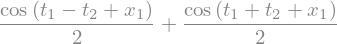

In [17]:
def compelx_square(x):
  return x*sp.conjugate(x)

k=compelx_square(t[0][0]) - compelx_square(t[1][0])
ans = sp.simplify(k)
ans

In [12]:
theta1 = 0.74
theta2 = -0.38
f1 = lambda x : np.cos(theta2) * np.cos(x + theta1)
f2 = lambda x : (np.cos(theta1 - theta2 + x) + np.cos(theta1 + theta2 + x)) / 2



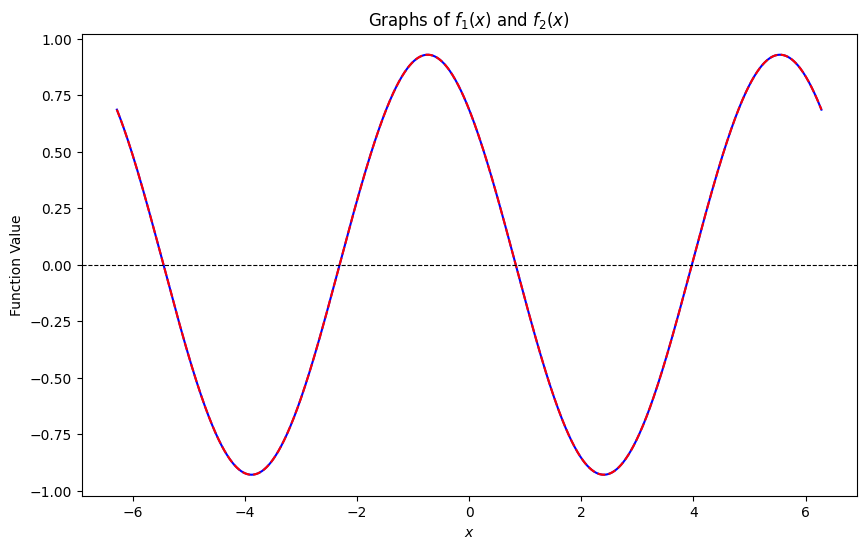

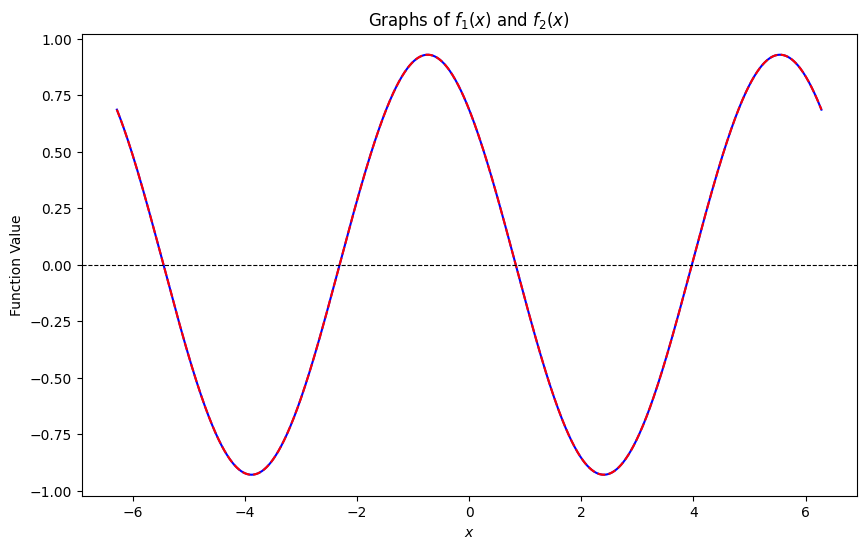

In [ ]:
import matplotlib.pyplot as plt


# Parameters
theta1 = 0.74
theta2 = -0.38

# Functions
f1 = lambda x: np.cos(theta2) * np.cos(x + theta1)
f2 = lambda x: (np.cos(theta1 - theta2 + x) + np.cos(theta1 + theta2 + x)) / 2

# x values
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
# Compute y values
y1 = f1(x)
y2 = f2(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label=r'$f_1(x) = \cos(\theta_2) \cos(x + \theta_1)$', color='blue')
plt.plot(x, y2, label=r'$f_2(x) = \frac{\cos(\theta_1 - \theta_2 + x) + \cos(\theta_1 + \theta_2 + x)}{2}$', color='red', linestyle='--')

# Customizing the plot
plt.title('Graphs of $f_1(x)$ and $f_2(x)$')
plt.xlabel('$x$')
plt.ylabel('Function Value')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at y = 0
plt.axvline(0, color='black', linewidth=0)
